# Modeling and Simulation in Python

Chapter 20

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [44]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

And defining the initial state.

In [45]:
init = State(y=381 * m, 
             v=0 * m/s)

,values
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [46]:
g = 9.8 * m/s**2

<Quantity(9.8, 'meter / second ** 2')>

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [47]:
t_end = 10 * s

<Quantity(10, 'second')>

Now we make a `System` object.

In [48]:
system = System(init=init, g=g, t_end=t_end)

,values
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
t_end,10 second


And define the slope function.

In [49]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    

    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [50]:
dydt, dvdt = slope_func(init, 0, system)
print(dydt)
print(dvdt)

0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to call `run_ode_solver`

In [51]:
results, details = run_ode_solver(system, slope_func, max_step=0.5*s)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results:

In [52]:
results

,y,v
0.000000,381.000000,0.000000
0.000102,381.000000,-0.001000
0.001122,380.999994,-0.011000
0.011327,380.999371,-0.111000
0.113367,380.937025,-1.110997
0.613367,379.156526,-6.010997
1.113367,374.926028,-10.910997
1.613367,368.245529,-15.810997
2.113367,359.115031,-20.710997
2.613367,347.534532,-25.610997


And here's position as a function of time:

Saving figure to file figs/chap09-fig01.pdf


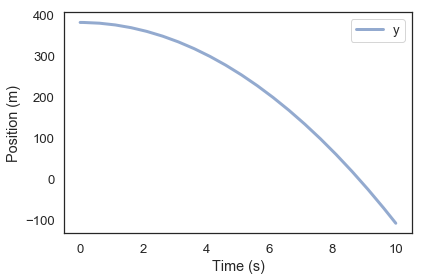

In [53]:
def plot_position(results):
    plot(results.y, label='y')
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

plot_position(results)
savefig('figs/chap09-fig01.pdf')

### Onto the sidewalk

To figure out when the penny hit the sidewalk, we can use `crossings`, which finds the times where a `Series` passes through a given value.

In [54]:
t_crossings = crossings(results.y, 0)

array([8.81788535])

For this example there should be just one crossing, the time when the penny hits the sidewalk.

In [55]:
t_sidewalk = t_crossings[0] * s

<Quantity(8.817885349720552, 'second')>

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [56]:
sqrt(2 * init.y / g)

<Quantity(8.817885349720552, 'second')>

The estimate is accurate to about 10 decimal places.

## Events

Instead of running the simulation until the penny goes through the sidewalk, it would be better to detect the point where the penny hits the sidewalk and stop.  `run_ode_solver` provides exactly the tool we need, **event functions**.

Here's an event function that returns the height of the penny above the sidewalk:

In [57]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And here's how we pass it to `run_ode_solver`.  The solver should run until the event function returns 0, and then terminate.

In [58]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[8.81788534972056]]
nfev,38
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


The message from the solver indicates the solver stopped because the event we wanted to detect happened.

Here are the results:

In [59]:
results

,y,v
0.000000,3.810000e+02,0.000000
0.000102,3.810000e+02,-0.001000
0.001122,3.810000e+02,-0.011000
0.011327,3.809994e+02,-0.111000
0.113367,3.809370e+02,-1.110997
1.133773,3.747013e+02,-11.110971
8.817885,5.684342e-14,-86.415276


With the `events` option, the solver returns the actual time steps it computed, which are not necessarily equally spaced. 

The last time step is when the event occurred:

In [60]:
t_sidewalk = get_last_label(results) * s

<Quantity(8.81788534972056, 'second')>

Unfortunately, `run_ode_solver` does not carry the units through the computation, so we have to put them back at the end.

We could also get the time of the event from `details`, but it's a minor nuisance because it comes packed in an array:

In [61]:
details.t_events[0][0] * s

<Quantity(8.81788534972056, 'second')>

The result is accurate to about 15 decimal places.

We can also check the velocity of the penny when it hits the sidewalk:

In [62]:
v_sidewalk = get_last_value(results.v) * m / s

<Quantity(-86.41527642726152, 'meter / second')>

And convert to kilometers per hour.

In [63]:
km = UNITS.kilometer
h = UNITS.hour
v_sidewalk.to(km / h)

<Quantity(-311.0949951381415, 'kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.

## Under the hood

Here is the source code for `crossings` so you can see what's happening under the hood:

In [64]:
%psource crossings

The [documentation of InterpolatedUnivariateSpline is here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html).

And you can read the [documentation of `scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to learn more about how `run_ode_solver` works.

### Exercises

**Exercise:** Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_ode_solver` to answer this question.

Here are some suggestions about how to proceed:

1.  Look up the Law of Universal Gravitation and any constants you need.  I suggest you work entirely in SI units: meters, kilograms, and Newtons.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.

You might also be interested to know that [it's actually not that easy to get to the Sun](https://www.theatlantic.com/science/archive/2018/08/parker-solar-probe-launch-nasa/567197/).

In [65]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton;
AU = UNITS.astronomical_unit

<Unit('astronomical_unit')>

In [81]:

G=6.67408e-11*N/kg**2*m**2
E_mass = 5.972e24*kg
S_mass = 1.989e30*kg
init_v = 0*m/s
init_r = 149.6e9*m
# init_r = 1 * AU
init_state = State(distance = init_r, velocity = init_v)
t_0 = 0*s
t_end = 1e10*s

system = System(init = init_state,
                G = G,
                mE = E_mass, 
                mS = S_mass,
                r_final = 701879000*m,
                t_0 = t_0, 
                t_end = t_end)
init_r


<Quantity(149600000000.0, 'meter')>

In [82]:
def gravity_function(state, system):
    """Computes Gravitational Force"""
    unpack(system)
    r,v = state
    
    F = (G*mE*mS)/(r**2)
    
    return F

In [83]:
gravity_function(init_state, system)

<Quantity(3.5422793159941665e+22, 'newton')>

In [84]:
def event_function(state, t, system):
    """Return the distance between the Earth and the Sun.
    """
    r, v = state
    
    return r - system.r_final

In [85]:
def slope_function(state, t, system):
    """Computes Gravitational Force"""
    
    
    unpack(system)
    r,v = state

    F= gravity_function(state,system)    
    
    
    drdt = v
    dvdt = -F/mE
    
    
    
    return drdt, dvdt

    

In [86]:
slope_function(init,0,system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-0.00593147909577054, 'newton / kilogram')>)

                  distance       velocity
0.000000e+00  1.496000e+11       0.000000
8.688737e-07  1.496000e+11      -0.000445
9.557611e-06  1.496000e+11      -0.004898
9.644498e-05  1.496000e+11      -0.049426
9.653187e-04  1.496000e+11      -0.494706
9.654056e-03  1.496000e+11      -4.947509
9.654143e-02  1.495998e+11     -49.475576
9.654151e-01  1.495794e+11    -494.801251
9.654152e+00  1.475270e+11   -4993.754437
4.075652e+01  1.090898e+11  -25666.330895
5.497271e+01  6.658088e+10  -47065.117624
5.985474e+01  4.329986e+10  -66029.154352
6.278422e+01  2.337337e+10  -97988.811227
6.336153e+01  1.813109e+10 -113516.699062
6.397801e+01  1.132625e+10 -147265.210670
6.437693e+01  5.315285e+09 -220022.430831
6.444647e+01  3.890267e+09 -258276.734888
6.450937e+01  2.310158e+09 -336775.850445
6.453771e+01  1.384620e+09 -436216.764840
6.455123e+01  8.097500e+08 -571422.224833
6.455334e+01  7.018790e+08 -613968.819092
sol                                  None
t_events            [[5577408.9601

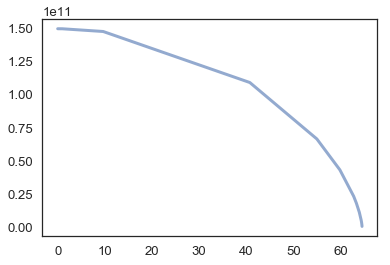

In [87]:

results, details = run_ode_solver(system, slope_function, events = event_function)

# results, details = run_ode_solver(system, slope_function)
results.index /= 60*60*24 #converts to days
print(results)
plot(results.distance)
print(details)
# plot(results.velocity)

In [31]:
# Solution goes here

In [32]:
# Solution goes here

In [33]:
# Solution goes here

In [34]:
# Solution goes here

In [35]:
# Solution goes here

In [36]:
# Solution goes here

In [37]:
# Solution goes here

In [38]:
# Solution goes here

In [39]:
# Solution goes here

In [40]:
# Solution goes here

In [41]:
# Solution goes here

In [42]:
# Solution goes here